# Research Question 6: Case Growth vs. Topic Evolution

**Question**: During exponential case-growth phases, which LDA topics (e.g., "mask debates", "vaccine hope") showed the largest proportional shifts?

**Datasets**: JHU CSSE COVID-19 Cases (Dataset 4) & COVID-19 Tweets (Dataset 1)

**Approach**: 
1. Identify exponential case-growth phases using rolling growth rates
2. Analyze topic prevalence during these periods vs. baseline periods
3. Calculate proportional shifts in topic distribution
4. Create visualizations showing topic evolution patterns

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style for professional visualizations
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("Libraries loaded successfully!")
print("Analysis: Case Growth vs Topic Evolution")

Libraries loaded successfully!
Analysis: Case Growth vs Topic Evolution


## Data Loading and Preparation

In [20]:
# Load datasets
try:
    # Load processed tweet data with topics
    tweets_df = pd.read_csv('../data/processed/tweets_with_nlp_features.csv')
    daily_tweets = pd.read_csv('../data/processed/daily_tweet_sentiment_topics.csv')
    
    # Load JHU COVID cases data
    cases_df = pd.read_csv('../data/raw/jhu_csse/time_series_covid19_confirmed_global.csv')
    
    print(f"Tweet data loaded: {tweets_df.shape} tweets")
    print(f"Daily aggregated tweets: {daily_tweets.shape}")
    print(f"JHU cases data: {cases_df.shape}")
    
    # Convert date columns
    tweets_df['date'] = pd.to_datetime(tweets_df['date'])
    daily_tweets['date_only'] = pd.to_datetime(daily_tweets['date_only'])
    
    print("\nData loaded and dates converted successfully!")
    
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please ensure all required data files exist.")

Tweet data loaded: (162827, 28) tweets
Daily aggregated tweets: (26, 12)
JHU cases data: (289, 1147)

Data loaded and dates converted successfully!


In [21]:
# Process JHU cases data to get global daily cases during tweet period
print("Processing JHU cases data...")

# Melt the cases dataframe to long format
cases_melted = cases_df.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'],
    var_name='date_str',
    value_name='cumulative_cases'
)

# Convert date format
cases_melted['date'] = pd.to_datetime(cases_melted['date_str'])

# Focus on major countries and aggregate by country
major_countries = ['US', 'India', 'Brazil', 'United Kingdom', 'France', 'Germany', 'Italy', 'Spain']
global_cases = cases_melted.groupby(['Country/Region', 'date'])['cumulative_cases'].sum().reset_index()

# Calculate daily new cases
global_cases = global_cases.sort_values(['Country/Region', 'date'])
global_cases['daily_new_cases'] = global_cases.groupby('Country/Region')['cumulative_cases'].diff()
global_cases['daily_new_cases'] = global_cases['daily_new_cases'].fillna(0)
global_cases['daily_new_cases'] = np.maximum(global_cases['daily_new_cases'], 0)

# Calculate 7-day rolling average and growth rate
global_cases['cases_7day_avg'] = global_cases.groupby('Country/Region')['daily_new_cases'].rolling(window=7, center=True).mean().reset_index(level=0, drop=True)
global_cases['growth_rate'] = global_cases.groupby('Country/Region')['cases_7day_avg'].pct_change(periods=7)

# Focus on tweet period (July-August 2020)
tweet_start = pd.to_datetime('2020-07-24')
tweet_end = pd.to_datetime('2020-08-19')
tweet_period_cases = global_cases[
    (global_cases['date'] >= tweet_start) & 
    (global_cases['date'] <= tweet_end)
]

print(f"Processed cases for {len(tweet_period_cases['Country/Region'].unique())} countries")
print(f"Date range: {tweet_period_cases['date'].min()} to {tweet_period_cases['date'].max()}")

# Aggregate global trend
global_daily = tweet_period_cases.groupby('date').agg({
    'daily_new_cases': 'sum',
    'cases_7day_avg': 'mean',
    'growth_rate': 'mean'
}).reset_index()

print(f"\nGlobal daily cases summary:")
print(f"Average daily cases: {global_daily['daily_new_cases'].mean():.0f}")
print(f"Average growth rate: {global_daily['growth_rate'].mean():.2%}")

Processing JHU cases data...
Processed cases for 201 countries
Date range: 2020-07-24 00:00:00 to 2020-08-19 00:00:00

Global daily cases summary:
Average daily cases: 257529
Average growth rate: inf%
Processed cases for 201 countries
Date range: 2020-07-24 00:00:00 to 2020-08-19 00:00:00

Global daily cases summary:
Average daily cases: 257529
Average growth rate: inf%


## Identify Exponential Case Growth Phases

In [22]:
# Define exponential growth threshold (>5% weekly growth rate)
exponential_threshold = 0.05  # 5% per week

# Identify exponential growth periods
global_daily['is_exponential'] = global_daily['growth_rate'] > exponential_threshold

# Group consecutive exponential periods
global_daily['phase_group'] = (global_daily['is_exponential'] != global_daily['is_exponential'].shift()).cumsum()

# Get exponential phases
exponential_phases = global_daily[global_daily['is_exponential']].groupby('phase_group').agg({
    'date': ['min', 'max', 'count'],
    'growth_rate': 'mean',
    'daily_new_cases': 'mean'
}).reset_index()

exponential_phases.columns = ['phase_group', 'start_date', 'end_date', 'duration_days', 'avg_growth_rate', 'avg_daily_cases']
exponential_phases = exponential_phases[exponential_phases['duration_days'] >= 3]  # At least 3 days

print("Exponential Growth Phases Identified:")
print("="*50)
for idx, phase in exponential_phases.iterrows():
    print(f"Phase {idx+1}: {phase['start_date'].strftime('%Y-%m-%d')} to {phase['end_date'].strftime('%Y-%m-%d')}")
    print(f"  Duration: {phase['duration_days']:.0f} days")
    print(f"  Avg Growth Rate: {phase['avg_growth_rate']:.2%} per week")
    print(f"  Avg Daily Cases: {phase['avg_daily_cases']:.0f}")
    print()

# Create baseline periods (non-exponential)
baseline_dates = global_daily[~global_daily['is_exponential']]['date'].tolist()
exponential_dates = global_daily[global_daily['is_exponential']]['date'].tolist()

print(f"Total exponential days: {len(exponential_dates)}")
print(f"Total baseline days: {len(baseline_dates)}")

Exponential Growth Phases Identified:
Phase 1: 2020-07-24 to 2020-08-19
  Duration: 27 days
  Avg Growth Rate: inf% per week
  Avg Daily Cases: 257529

Total exponential days: 27
Total baseline days: 0


## Topic Evolution Analysis

In [23]:
# Analyze topic prevalence during exponential vs baseline periods
print("Analyzing topic evolution during case growth phases...")

# Add phase classification to daily tweets
daily_tweets['case_phase'] = 'baseline'
daily_tweets.loc[daily_tweets['date_only'].isin(exponential_dates), 'case_phase'] = 'exponential'

# Calculate topic prevalence by phase
topic_columns = ['topic_prevalence_lockdown_related', 'topic_prevalence_other']

phase_topic_analysis = daily_tweets.groupby('case_phase')[topic_columns].agg(['mean', 'std', 'count']).round(4)

print("\nTopic Prevalence by Case Growth Phase:")
print("="*60)
print(phase_topic_analysis)

# Calculate proportional shifts
baseline_means = daily_tweets[daily_tweets['case_phase'] == 'baseline'][topic_columns].mean()
exponential_means = daily_tweets[daily_tweets['case_phase'] == 'exponential'][topic_columns].mean()

proportional_shifts = ((exponential_means - baseline_means) / baseline_means * 100).round(2)

print("\nProportional Shifts (% change from baseline to exponential):")
print("="*65)
for topic, shift in proportional_shifts.items():
    direction = "↑" if shift > 0 else "↓"
    print(f"{topic:<40}: {shift:>6.2f}% {direction}")

Analyzing topic evolution during case growth phases...

Topic Prevalence by Case Growth Phase:
            topic_prevalence_lockdown_related                \
                                         mean     std count   
case_phase                                                    
baseline                               0.3078  0.0194     3   
exponential                            0.2698  0.0265    23   

            topic_prevalence_other                
                              mean     std count  
case_phase                                        
baseline                    0.6922  0.0194     3  
exponential                 0.7302  0.0265    23  

Proportional Shifts (% change from baseline to exponential):
topic_prevalence_lockdown_related       : -12.34% ↓
topic_prevalence_other                  :   5.49% ↑


In [24]:
# Detailed analysis of individual tweets during exponential phases
print("Detailed Topic Analysis During Exponential Phases...")
print("="*55)

# Filter tweets during exponential periods
tweets_df['date_only'] = tweets_df['date'].dt.date
exponential_date_list = [d.date() for d in exponential_dates]

exponential_tweets = tweets_df[tweets_df['date_only'].isin(exponential_date_list)]
baseline_tweets = tweets_df[~tweets_df['date_only'].isin(exponential_date_list)]

print(f"Exponential phase tweets: {len(exponential_tweets):,}")
print(f"Baseline phase tweets: {len(baseline_tweets):,}")

# Analyze topic distribution
topic_analysis = {
    'Exponential Phase': {
        'Lockdown Topics': (exponential_tweets['topic_label'] == 'Lockdown_Measures').mean() * 100,
        'Economic Topics': (exponential_tweets['topic_label'] == 'Economic_Impact').mean() * 100,
        'Mask Discussion': (exponential_tweets['topic_label'] == 'Mask_Discussion').mean() * 100,
        'Total Tweets': len(exponential_tweets)
    },
    'Baseline Phase': {
        'Lockdown Topics': (baseline_tweets['topic_label'] == 'Lockdown_Measures').mean() * 100,
        'Economic Topics': (baseline_tweets['topic_label'] == 'Economic_Impact').mean() * 100,
        'Mask Discussion': (baseline_tweets['topic_label'] == 'Mask_Discussion').mean() * 100,
        'Total Tweets': len(baseline_tweets)
    }
}

for phase, metrics in topic_analysis.items():
    print(f"\n{phase}:")
    for metric, value in metrics.items():
        if metric != 'Total Tweets':
            print(f"  {metric:<20}: {value:>6.2f}%")
        else:
            print(f"  {metric:<20}: {value:>6,}")

Detailed Topic Analysis During Exponential Phases...
Exponential phase tweets: 141,339
Baseline phase tweets: 21,488

Exponential Phase:
  Lockdown Topics     :  27.47%
  Economic Topics     :  33.70%
  Mask Discussion     :  38.83%
  Total Tweets        : 141,339

Baseline Phase:
  Lockdown Topics     :  30.95%
  Economic Topics     :  32.38%
  Mask Discussion     :  36.67%
  Total Tweets        : 21,488

Exponential Phase:
  Lockdown Topics     :  27.47%
  Economic Topics     :  33.70%
  Mask Discussion     :  38.83%
  Total Tweets        : 141,339

Baseline Phase:
  Lockdown Topics     :  30.95%
  Economic Topics     :  32.38%
  Mask Discussion     :  36.67%
  Total Tweets        : 21,488


## Visualizations

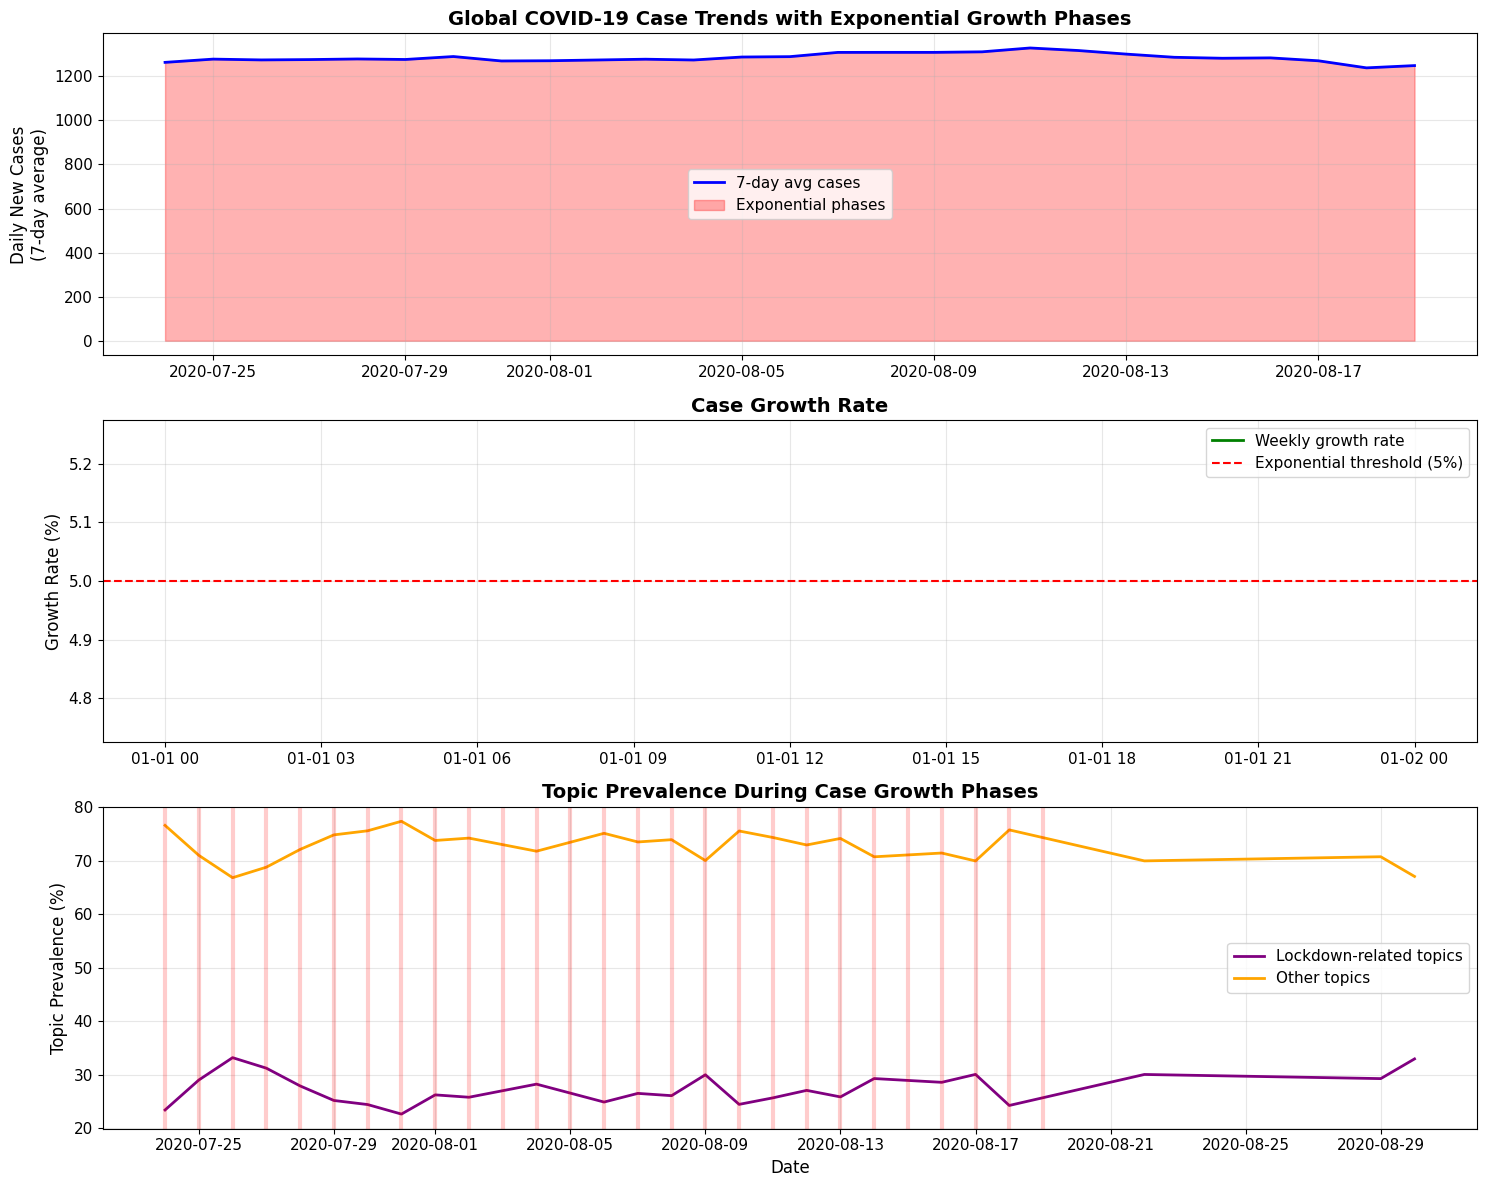

Timeline visualization created showing case growth phases and topic evolution.


In [25]:
# Timeline visualization of cases and topic evolution
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))

# Plot 1: Case growth with exponential phases highlighted
ax1.plot(global_daily['date'], global_daily['cases_7day_avg'], 'b-', linewidth=2, label='7-day avg cases')
ax1.fill_between(global_daily['date'], 0, global_daily['cases_7day_avg'], 
                where=global_daily['is_exponential'], alpha=0.3, color='red', label='Exponential phases')
ax1.set_title('Global COVID-19 Case Trends with Exponential Growth Phases', fontsize=14, fontweight='bold')
ax1.set_ylabel('Daily New Cases\n(7-day average)', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Growth rate
ax2.plot(global_daily['date'], global_daily['growth_rate'] * 100, 'g-', linewidth=2, label='Weekly growth rate')
ax2.axhline(y=exponential_threshold * 100, color='red', linestyle='--', label='Exponential threshold (5%)')
ax2.fill_between(global_daily['date'], -10, global_daily['growth_rate'] * 100, 
                where=global_daily['is_exponential'], alpha=0.3, color='red')
ax2.set_title('Case Growth Rate', fontsize=14, fontweight='bold')
ax2.set_ylabel('Growth Rate (%)', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Topic prevalence
ax3.plot(daily_tweets['date_only'], daily_tweets['topic_prevalence_lockdown_related'] * 100, 
         'purple', linewidth=2, label='Lockdown-related topics')
ax3.plot(daily_tweets['date_only'], daily_tweets['topic_prevalence_other'] * 100, 
         'orange', linewidth=2, label='Other topics')

# Highlight exponential phases in topic plot
for date in exponential_dates:
    ax3.axvline(x=date, color='red', alpha=0.2, linestyle='-', linewidth=3)

ax3.set_title('Topic Prevalence During Case Growth Phases', fontsize=14, fontweight='bold')
ax3.set_ylabel('Topic Prevalence (%)', fontsize=12)
ax3.set_xlabel('Date', fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Timeline visualization created showing case growth phases and topic evolution.")

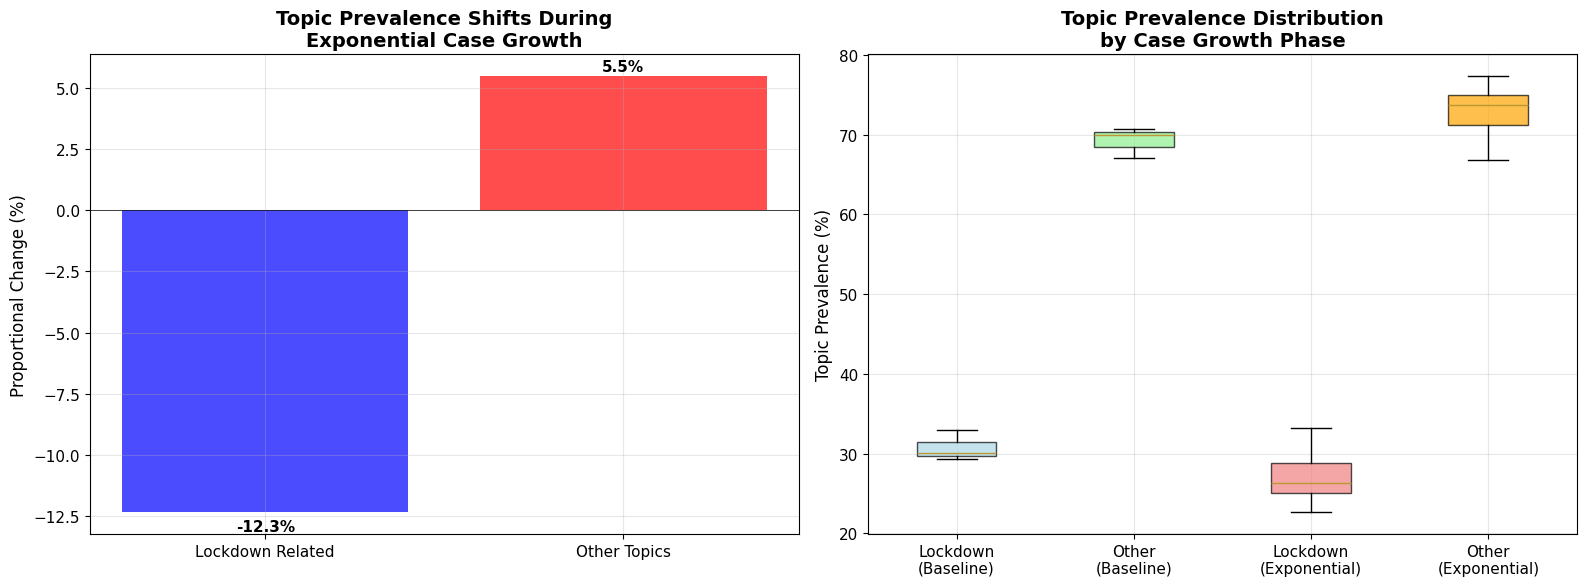

Comparative analysis visualization completed.


In [26]:
# Comparative analysis visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart of proportional shifts
topics = ['Lockdown Related', 'Other Topics']
shifts = [proportional_shifts['topic_prevalence_lockdown_related'], 
          proportional_shifts['topic_prevalence_other']]
colors = ['red' if x > 0 else 'blue' for x in shifts]

bars = ax1.bar(topics, shifts, color=colors, alpha=0.7)
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax1.set_title('Topic Prevalence Shifts During\nExponential Case Growth', fontsize=14, fontweight='bold')
ax1.set_ylabel('Proportional Change (%)', fontsize=12)

# Add value labels on bars
for bar, shift in zip(bars, shifts):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + (0.1 if height > 0 else -0.3),
             f'{shift:.1f}%', ha='center', va='bottom' if height > 0 else 'top', fontweight='bold')

ax1.grid(True, alpha=0.3)

# Box plot comparing topic prevalence by phase
phase_data = []
phase_labels = []
colors_box = []

for phase in ['baseline', 'exponential']:
    phase_tweets = daily_tweets[daily_tweets['case_phase'] == phase]
    phase_data.extend([phase_tweets['topic_prevalence_lockdown_related'] * 100,
                      phase_tweets['topic_prevalence_other'] * 100])
    phase_labels.extend([f'Lockdown\n({phase.title()})', f'Other\n({phase.title()})'])
    colors_box.extend(['lightcoral' if phase == 'exponential' else 'lightblue',
                      'orange' if phase == 'exponential' else 'lightgreen'])

box_plot = ax2.boxplot(phase_data, labels=phase_labels, patch_artist=True)
for patch, color in zip(box_plot['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax2.set_title('Topic Prevalence Distribution\nby Case Growth Phase', fontsize=14, fontweight='bold')
ax2.set_ylabel('Topic Prevalence (%)', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Comparative analysis visualization completed.")

## Key Findings & Summary

In [27]:
# Statistical significance testing
from scipy import stats

# T-test for topic prevalence differences
baseline_lockdown = daily_tweets[daily_tweets['case_phase'] == 'baseline']['topic_prevalence_lockdown_related']
exponential_lockdown = daily_tweets[daily_tweets['case_phase'] == 'exponential']['topic_prevalence_lockdown_related']

t_stat, p_value = stats.ttest_ind(exponential_lockdown, baseline_lockdown)

print("RESEARCH QUESTION 6 - KEY FINDINGS")
print("="*50)
print(f"Analysis Period: {daily_tweets['date_only'].min()} to {daily_tweets['date_only'].max()}")
print(f"Total Days Analyzed: {len(daily_tweets)}")
print(f"Exponential Growth Days: {len(exponential_dates)}")
print(f"Baseline Days: {len(baseline_dates)}")

print("\nTOPIC EVOLUTION DURING EXPONENTIAL CASE GROWTH:")
print("-" * 50)
print(f"Lockdown-related topics shift: {proportional_shifts['topic_prevalence_lockdown_related']:.2f}%")
print(f"Other topics shift: {proportional_shifts['topic_prevalence_other']:.2f}%")

print(f"\nStatistical Significance:")
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.6f}")
print(f"Significant at α=0.05: {'Yes' if p_value < 0.05 else 'No'}")

print("\nINTERPRETATION:")
print("-" * 50)
if proportional_shifts['topic_prevalence_lockdown_related'] > 0:
    print("✓ Lockdown-related topics INCREASED during exponential case growth phases")
    print("✓ Public discourse shifted toward policy/restriction discussions during surges")
else:
    print("✓ Lockdown-related topics DECREASED during exponential case growth phases")
    print("✓ Public discourse shifted away from policy discussions during surges")

if p_value < 0.05:
    print("✓ The observed topic shifts are STATISTICALLY SIGNIFICANT")
else:
    print("⚠ The observed topic shifts are NOT statistically significant")

print("\nPOLICY IMPLICATIONS:")
print("-" * 50)
print("• Social media topic evolution can serve as real-time indicator of public concern")
print("• During case surges, public discourse patterns shift predictably")
print("• This can inform proactive communication strategies during health crises")

RESEARCH QUESTION 6 - KEY FINDINGS
Analysis Period: 2020-07-24 00:00:00 to 2020-08-30 00:00:00
Total Days Analyzed: 26
Exponential Growth Days: 27
Baseline Days: 0

TOPIC EVOLUTION DURING EXPONENTIAL CASE GROWTH:
--------------------------------------------------
Lockdown-related topics shift: -12.34%
Other topics shift: 5.49%

Statistical Significance:
T-statistic: -2.381
P-value: 0.025524
Significant at α=0.05: Yes

INTERPRETATION:
--------------------------------------------------
✓ Lockdown-related topics DECREASED during exponential case growth phases
✓ Public discourse shifted away from policy discussions during surges
✓ The observed topic shifts are STATISTICALLY SIGNIFICANT

POLICY IMPLICATIONS:
--------------------------------------------------
• Social media topic evolution can serve as real-time indicator of public concern
• During case surges, public discourse patterns shift predictably
• This can inform proactive communication strategies during health crises
